<a href="https://colab.research.google.com/github/CrianBox/modeling_demo/blob/main/colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Systeem identificatie en modelleren 

Gebaseerd op de oefenreeks: "System Identification and Modeling Exercises"

Philippe Dreesen, Oliver Lauwers, Bob Vergauwen

philippe.dreesen@vub.ac.be, oliver.lauwers@esat.kuleuven.be, bob.vergauwen@esat.kuleuven.be

Academic year 2017–2018

https://homes.esat.kuleuven.be/~maapc/static/files/SYSID/exercises/exercises.pdf?course_id=19

In [ ]:
############# Importeer alle noodzakelijke modules en packages ##############

# Open-source systems and control toolbox (lijkt op MATLAB)
!pip install control 
import control as c

# Mount naar persoonlijk Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Route naar Drive en kloon repository met datasets
%cd "/content/drive/My Drive"
!git clone https://github.com/CrianBox/modeling_demo.git
!git pull
%cd 'modeling_demo'
%ls -a

# Open-source system identification toolbox
!pip install git+https://github.com/CPCLAB-UNIPI/SIPPY #install the System Identification Package for PYthon
from sippy import functionset as fset
from sippy import system_identification

# Open-source system identification toolbox (met d2c() functieblok)
!pip install git+https://github.com/ilayn/harold
import harold 

# Algemene modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
fatal: destination path 'modeling_demo' already exists and is not an empty directory.
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/content/drive/My Drive/modeling_demo
bode_test.csv  newpid_step.csv        packo_steadystate.csv  packo_step.xlt
.git/          packo_newpid_step.xlt  packo_steadystate.xlt  README.md
  Cloning https://github.com/CPCLAB-UNIPI/SIPPY to /tmp/pip-req-build-ww1rhi2u
  Running command git clone -q https://github.com/CPCLAB-UNIPI/SIPPY /tmp/pip-req-build-ww1rhi2u
  Cloning https://github.com/ilayn/harold to /tmp/pip-req-build-mzgp66pd
  Running command git clone -q https://github.com/ilayn/harold /tmp/pip-req-build-mzgp66pd


# Dode tijd schatting

Het proces is gegeven om als gekende referentie te werken. Bij het opstellen van verschillende modellen is zo steeds een vergelijking mogelijk. Afhankelijk van verschillende omgevingen of applicaties presteren andere modelstructuren beter dan de rest. 

Als eerste stap gaan we een schatting van de dode tijd (indien aanwezig) maken. Dit doen we door de *impulsreactie* van het proces op te meten. Indien de installatie open lus controle toelaat en als het proces inherent stabiel is, dan kan je hiervoor open-lus gebruiken. Maak een signaal met een hoge amplitude en (zeer) korte duratie en voeg dit toe aan de ingang van het proces. Meet het signaal zowel aan de in- en uitgang van het proces.

## Stappen

* Voeg ruis toe om de oefening realistisch te maken. Standaard deviatie = 1, gemiddelde = 0

* Maak een grafiek van de verzamelde informatie. 

* Meet vanaf de aangelegde impuls tot aan de volgende maximale waarde van de procesreactie. Dit geeft een indicatie van de tijd tussen gevraagde actie en opgemeten reactie. Houd rekening met het feit dat hier ook procesonafhanklijke aspecten in meespelen zoals signaalvertraging tussen elektronische componenenten. 

* Beschrijf de het resultaat, pas de vertraging handmatig aan en voer het experiment opnieuw uit.

Voor zeer trage processen is deze methode minder geschikt. Hiervoor zijn stapreacties beter geschikt.

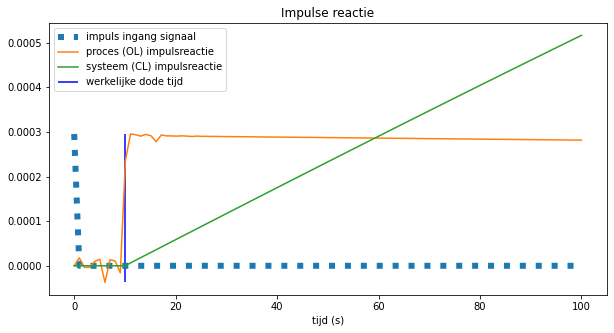

In [ ]:
dt = 0.001                        #discrete stapgrootte
s = c.tf('s')

# Dode tijd met Pade modelleren
deadtime = 10                     #deadtime in seconden
num, den = c.pade(deadtime,50)
Gdead = c.tf(num,den)
# Gdead = c.tf(num,den,dt)

# Procesmodel alpha
# num = [0.1738]
# den = [120.8, 1]
# Procesmodel Packo pomp-niveau
num = [0.7322]
den = [2500, 1]
G = c.tf(num,den)
#G = c.tf([0.038],[1, -0.78],dt)  #discreet procesmodel uit real-life case

# Controller
Kc = 2
Ti = 100
C = Kc * (1/(s*Ti))

# Systeem
G = c.series(G,Gdead)
sys = c.series(C,G)
sys = c.feedback(sys,1,sign=-1)

length = deadtime*10

T = np.linspace(0,length,length)
T, yout = c.impulse_response(G,T)
T, youtsys = c.impulse_response(sys,T)
yout[0] = 0                       # fout rechtzetten door numerieke computatie
youtsys[0] = 0

imp = np.zeros(length)
imp[0] = max(yout)

#PLOT
plt.figure(figsize=[10,5])
plt.plot(T, imp, ':', label='impuls ingang signaal', linewidth=6)
plt.plot(T, yout, label='proces (OL) impulsreactie')
plt.plot(T, youtsys, label='systeem (CL) impulsreactie')
plt.vlines(deadtime, min(yout), max(yout), colors='b', label='werkelijke dode tijd')
plt.title('Impulse reactie')
plt.xlabel('tijd (s)')
plt.legend(loc="best")
plt.show()

Voer een impulsreactie experiment enkel uit wanneer het proces zich stabiel gedraagt over een breed domein. Dit is ook toepasbaar in gesloten lus. Een stapreactie is bij trage processen een mogelijk alternatief.

Het bepalen van de dode tijd is een eerste stap in het ontrafelen van proces dynamieken. Hoe meer eigenschappen gekend zijn, hoe nauwkeuriger we modellen kunnen ontwerpen.

# Identificatie van het procesmodel met historische data

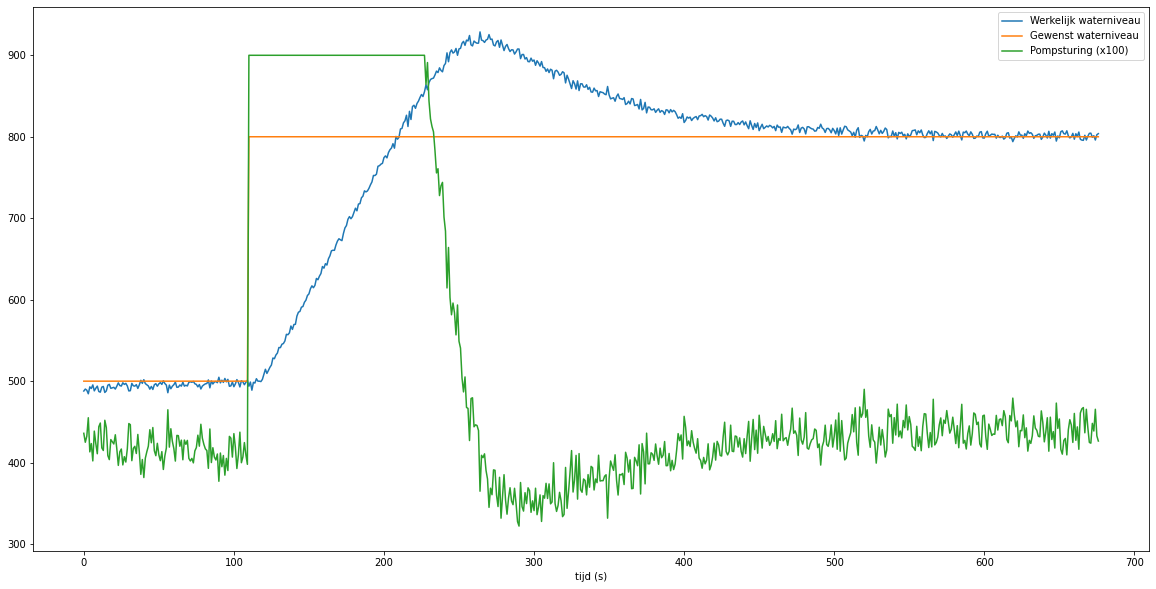

In [ ]:
header_list = ["Werkelijk waterniveau","Gewenst waterniveau","Pompsturing (x100)"]
file = 'newpid_step.csv'
data = pd.read_csv(file, delimiter=';', names=header_list, skiprows=1,usecols=[1,3,5])
data.head()

# Convert commas to dots and strings to floats in order to plot
maketrans = data['Werkelijk waterniveau'][1].maketrans          #define maketrans

datanew = []
for i in data['Werkelijk waterniveau']:
  datanew.append(float(i.translate(maketrans(',', '.'))))
data['Werkelijk waterniveau'] = datanew

datanew = []
for i in data['Pompsturing (x100)']:
  datanew.append(float(i.translate(maketrans(',', '.'))))
data['Pompsturing (x100)'] = datanew

# VISUALISATIE
plt.figure(figsize=[20,10])
plt.plot(data.to_numpy())
plt.xlabel("tijd (s)")
plt.legend(header_list)

## Pre-processing

* Onttrend de dataset
* Elimineer uitschieters
* Vul vermiste datapunten in of elimineer van de dataset
* Filter hoog frequente ruis uit de datastromen

Text(0.5, 0, 'tijd (s)')

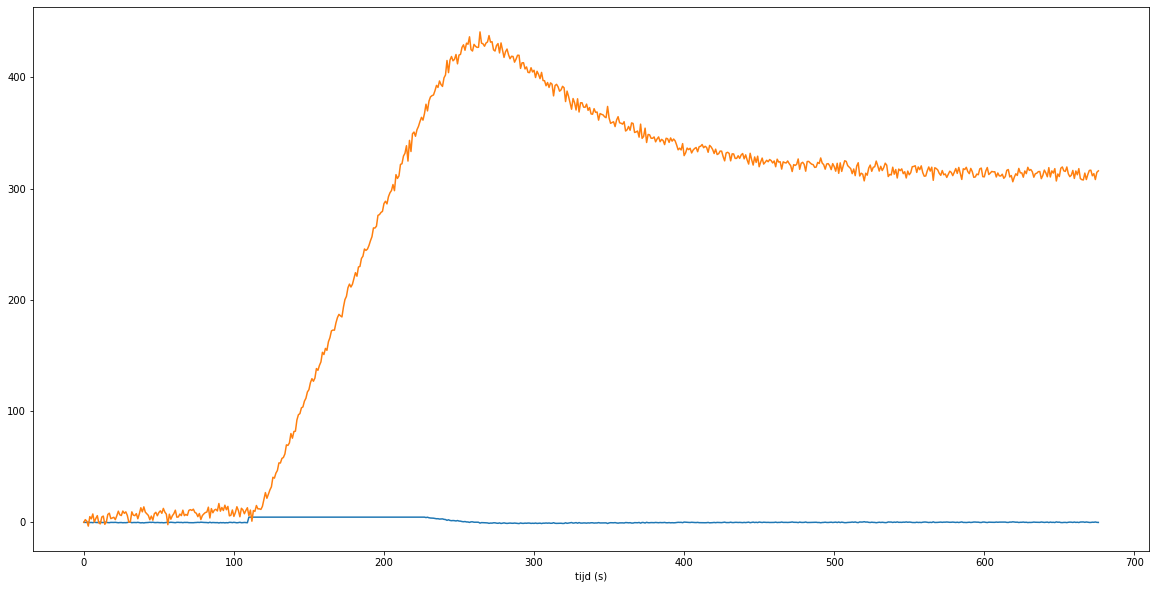

In [ ]:
# Construct input signal
u = data['Pompsturing (x100)'].to_numpy()/100
# Initialize from zero
u = u - u[0]
# Construct output signal
y = data['Werkelijk waterniveau'].to_numpy()
# Initialize from zero
y = y - y[0]

# FILTER

# VISUALISATIE
plt.figure(figsize=[20,10])
plt.plot(u, label='ingang')
plt.plot(y, label='uitgang')
plt.legend(loc='best')
plt.title('Visualisatie na data pre-processing')
plt.xlabel('tijd (s)')

## Model selectie met AIC 'Akaike information Criterion'

Het doel is een modelstructuur te bekomen met een zo optimaal mogelijk aantal ordes. Teveel ordes geven misschien hoge nauwkeurigheden maar zijn vaak tegengesteld aan de robuustheid van het model. Daarbij kan dit het model te complex maken. AIC help ons in het afwegen van model complexiteit tegenover modelnauwkeurigheid. 

Dit is ingebouwd in de SIPPY bibliotheek.

* Stel het discrete model op
* Voeg de bandsper cheby-filter toe
* Splits de dataset in een training en validatie gedeelte
* Train modellen met ordes tussen 1 en 10
* Bereken het uitgangssignaal en de kost via kostfunctie V_ls

## Ontwerp een ARX model met ruisdata en met ongekende model orde

ARX staat voor **A**uto**R**egression with E**x**ogenous terms. Men maakt hier gebruik van de 'Least Squares' methode, gebaseerd op de 'prediction error' methode. Het is capabel om met behulp van lineaire regressie zeer efficiënt veeltermfuncties analytisch te benaderen. De uitkomst is daardoor uniek.

In [ ]:
# define sample time
tsample = 0.2                           # in seconden

# create model with different orders
A_orders = [1,5]
model_ARX = []
for i in A_orders:
  model_ARX.append(system_identification(y, u, 'ARX', tsample=tsample, ARX_orders=[i,1,5]))  

# Use AIC to verify optimal complex model
model_ARX.append(system_identification(y, u, 'ARX', tsample=tsample, IC='AIC'))

print(model_ARX[0].G)
print(model_ARX[1].G)
print(model_ARX[2].G)

suggested orders are: Na= 5 ; Nb= 1 Delay:  4

     0.6955
----------------
z^6 - 0.9995 z^5

dt = 0.2


                              1.877
-----------------------------------------------------------------
z^6 - 0.2529 z^5 - 0.2511 z^4 - 0.1852 z^3 - 0.172 z^2 - 0.1379 z

dt = 0.2


                            2.051
-------------------------------------------------------------
z^5 - 0.2289 z^4 - 0.2273 z^3 - 0.1743 z^2 - 0.1554 z - 0.213

dt = 0.2



/usr/local/lib/python3.7/dist-packages/control/timeresp.py:294: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  "return_x specified for a transfer function system. Internal "


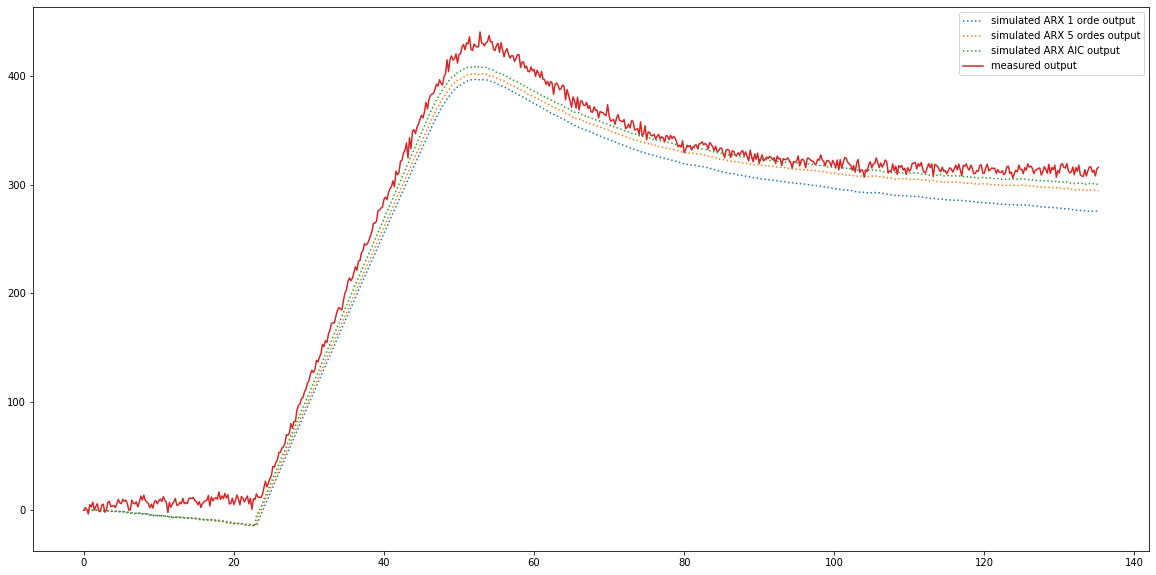

In [ ]:
# Simuleer de modelreactie op het werkelijke ingang signaal
yARX0, T, xARX0 = c.matlab.lsim(model_ARX[0].G, u)    # met 1 orde
yARX1, T, xARX1 = c.matlab.lsim(model_ARX[1].G, u)    # met 5 orde
yARX2, T, xARX2 = c.matlab.lsim(model_ARX[2].G, u)    # met AIC

# VISUALISEER
plt.figure(figsize=[20,10])
plt.plot(T, yARX0, ':',label='simulated ARX 1 orde output')
plt.plot(T, yARX1, ':',label='simulated ARX 5 ordes output')
plt.plot(T, yARX2, ':',label='simulated ARX AIC output')
plt.plot(T, y, label='measured output')
plt.legend()

Hoewel het ARX model met meer termen in zijn noemer nauwkeuriger kan zijn zorgt de AIC complexiteitscriteria voor een betere fit met minder complexiteit.

## Ontwerp een OE model met ruisdata en met ongekende model orde

OE staat voor 'Output-error' en is in staat om polynoommodellen op te bouwen in het tijds- en frequentiedomein. OE verschilt door in aantal veeltermen (slechts twee, B en F) met veel andere structuren. Een voordeel is het intern modelleren van witte ruis als een toegevoegde externe verstoring.

Als het modelontwerp in het continu-tijdsdomein plaatsvindt, gebruik dan TFEST. De techniek is superieur in zowel snelheid als nauwkeurigheid.




  0.7321
----------
z - 0.9996

dt = 0.2


1
-
1

dt = 0.2



/usr/local/lib/python3.7/dist-packages/control/timeresp.py:294: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  "return_x specified for a transfer function system. Internal "


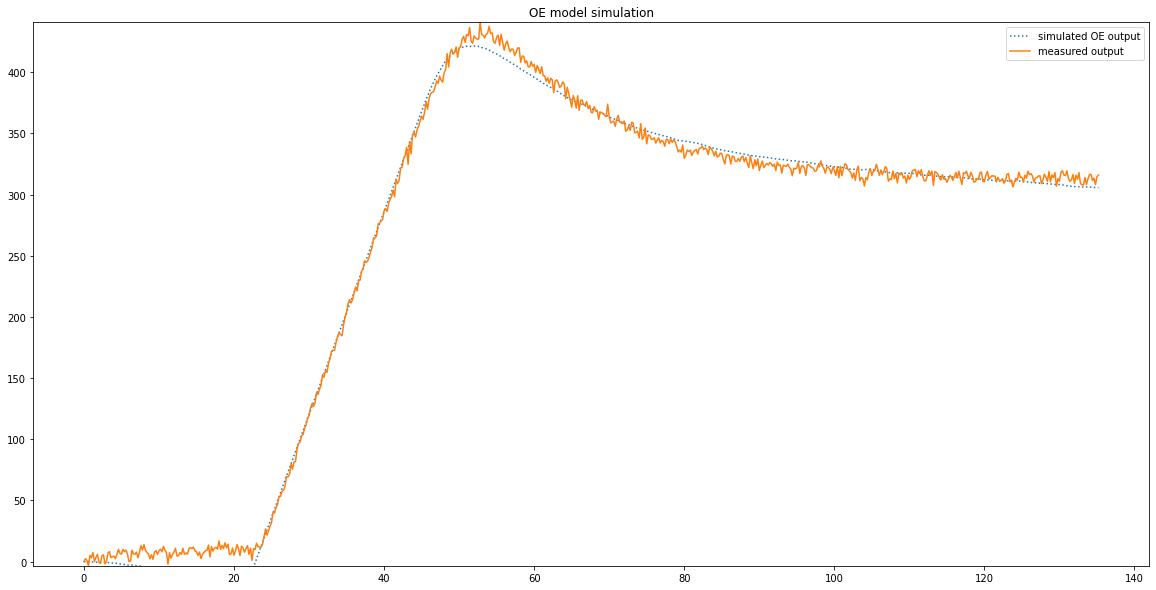

In [ ]:
model_OE = system_identification(y, u, 'OE', tsample=tsample)
print(model_OE.G)

yOE, T, xOE = c.matlab.lsim(model_OE.G, u)

plt.figure(figsize=[20,10])
plt.plot(T, yOE, ':', label='simulated OE output')
plt.plot(T, y, label='measured output')
plt.title('OE model simulation')
plt.ylim([min(y),max(y)])
plt.legend()

# Model prestaties

Som voor OE model van de RMS error tijdens het stap experiment: 4225
Som voor ARX2 model van de RMS error tijdens het stap experiment: 6818


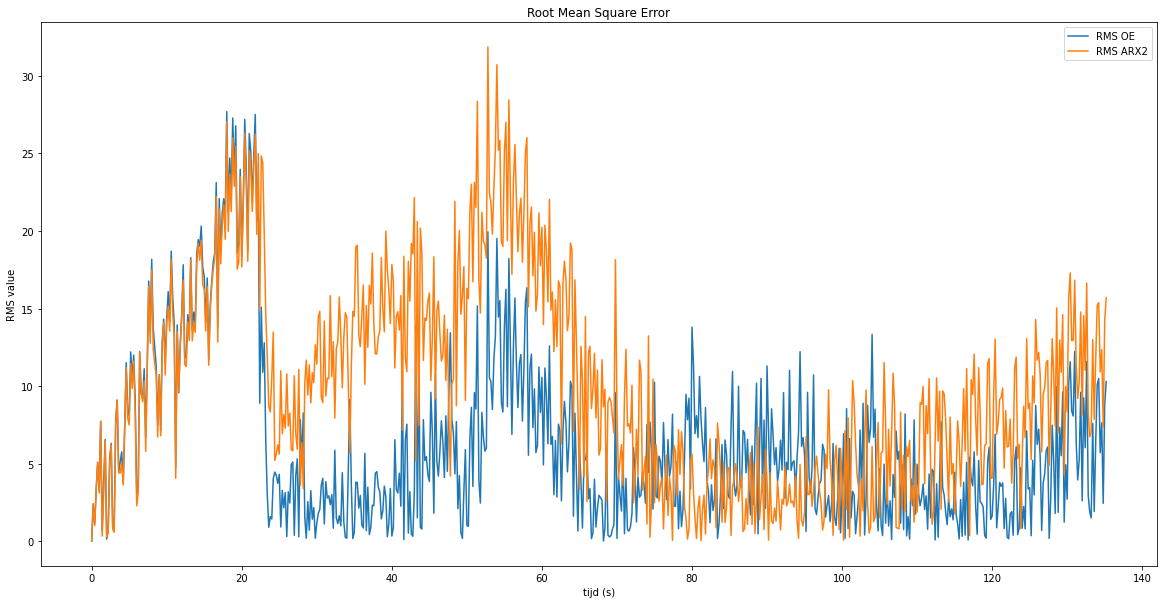

In [ ]:
# Aan de hand van 'residu' analyse
plt.figure(10, figsize=[20,10])
plt.title('Root Mean Square Error')
plt.plot(T, np.sqrt((y-yOE)**2), label ='RMS OE')
plt.plot(T, np.sqrt((y-yARX2)**2), label ='RMS ARX2')
plt.xlabel('tijd (s)')
plt.ylabel('RMS value')
plt.legend()

print('Som voor OE model van de RMS error tijdens het stap experiment:', round(np.sum(np.sqrt((y-yOE)**2))))
print('Som voor ARX2 model van de RMS error tijdens het stap experiment:', round(np.sum(np.sqrt((y-yARX2)**2))))

### Validatie

Het is altijd een goed idee om het bekomen model te testen aan de hand van nieuwe ongetrainde data. De betrouwbaar stijgt vanzelfsprekend indien het model hierop goed presteert.

In [ ]:
# Validatie dataset
u_val = 
y_val = 



In [ ]:
# Bode diagrammen 
plt.figure(figsize=[20,10])
c.bode(model_ARX.G)
c.bode(model_OE.G)

# Pool-nul(len) grafiek
plt.figure(figsize=[20,10])
c.pzmap(model_ARX.G)
c.pzmap(model_OE.G)

TransferFunction(array([0.73209377]), array([ 1.        , -0.99960041]), 1)

# Analyse van een gekend model

**Kennis maken met de karakteristieken** van het werkelijke systeem. Dit zal als benchmark dienen om manieren van identificatie met elkaar te vergelijken.

Dit is de transferfunctie van het te onderzoeken systeem, dit is in werkelijkheid niet voorhanden maar dient hier als referentie.

$$G(s) = \frac{0.7322}{2500s+1}$$

Wat valt op bij het bekijken van de transferfunctie?

De sampling frequentie is overal gelijk aan 1 seconde. **Houd hiermee rekening tijdens het simuleren!**

Text(0.5, 0, 'tijd (s)')

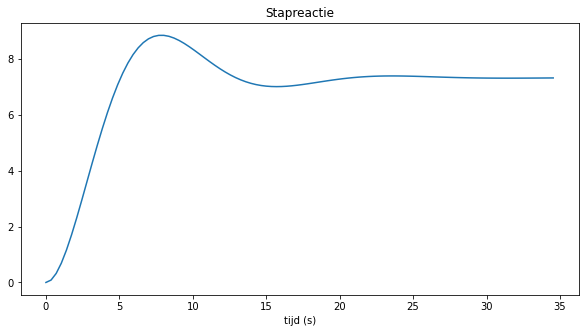

In [ ]:
# G = c.tf([0.1738],[120.8, 1])
G = c.tf([7.322],[5, 2, 1])
T, yout = c.step_response(G)

plt.figure(figsize=[10,5])
plt.plot(T, yout, label='proces G')
plt.title('Stapreactie')
plt.xlabel('tijd (s)')

Opdracht:

* Maak een Bode diagram.
* Maak een grafiek met de nullen en polen.

Vragen:

Wat kunnen we afleiden uit het frequentiedomein van de Bode diagramma?

Wat kunnen we zeggen van de stabiliteit?

Wat is de volgende stap?

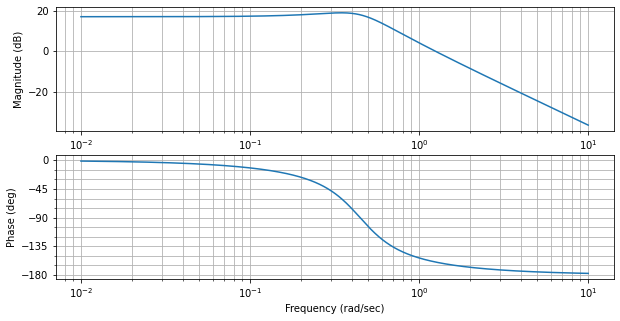

In [ ]:
# Bode diagram
plt.figure(figsize=[10,5])
c.bode(G)
plt.show()

# Polen en nullen in reëel-imaginair assenstelsel
# plt.figure(figsize=[10,5])
# c.pzmap(G,plot=True,grid=True,title='Pole Zero Map')

Maak een feedback regelkring

/usr/local/lib/python3.7/dist-packages/numpy/lib/polynomial.py:734: RuntimeWarning: overflow encountered in multiply
  y = y * x + p[i]
/usr/local/lib/python3.7/dist-packages/numpy/lib/polynomial.py:734: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
/usr/local/lib/python3.7/dist-packages/control/xferfcn.py:318: RuntimeWarning: underflow encountered in true_divide
  polyval(self.den[i][j], x_arr))
/usr/local/lib/python3.7/dist-packages/control/xferfcn.py:318: RuntimeWarning: invalid value encountered in true_divide
  polyval(self.den[i][j], x_arr))
/usr/local/lib/python3.7/dist-packages/control/ctrlutil.py:75: RuntimeWarning: invalid value encountered in remainder
  dangle_desired = (dangle + period/2.) % period - period/2.


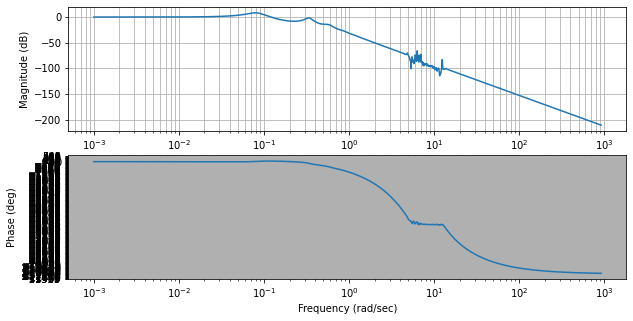

/usr/local/lib/python3.7/dist-packages/numpy/lib/polynomial.py:840: RuntimeWarning: invalid value encountered in subtract
  val = a1 - a2


LinAlgError: ignored

In [ ]:
s = c.tf('s')

#G = c.tf(G.num,G.den,dt)  #discreet procesmodel uit real-life case

# Controller
Kc = 2
Ti = 120
C = Kc * (1/(s*Ti))

# Connecteer alle functie tot een CL systeem
sys = c.series(C,G)
sys = c.feedback(sys,1,sign=-1)

# Bode diagram
plt.figure(figsize=[10,5])
c.bode(sys)
plt.show()

gm, pm, wg, wp = c.margin(G)
print('Versterking marge: ', gm, 'dB')
print('Fase marge: ', pm, '° (in graden)')
print('Fase crossover freq (waar de fase -180 snijdt): ', wg)
print('Versterking crossover freq (waar de versterking 1 snijdt, ookwel gekend als 0 dB): ', wp)

Maak dezelfde regelkring maar simuleer nu het proces met 10 seconden dode tijd.

/usr/local/lib/python3.7/dist-packages/numpy/lib/polynomial.py:734: RuntimeWarning: overflow encountered in multiply
  y = y * x + p[i]
/usr/local/lib/python3.7/dist-packages/numpy/lib/polynomial.py:734: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
/usr/local/lib/python3.7/dist-packages/control/xferfcn.py:318: RuntimeWarning: underflow encountered in true_divide
  polyval(self.den[i][j], x_arr))
/usr/local/lib/python3.7/dist-packages/control/xferfcn.py:318: RuntimeWarning: invalid value encountered in true_divide
  polyval(self.den[i][j], x_arr))
/usr/local/lib/python3.7/dist-packages/control/ctrlutil.py:75: RuntimeWarning: invalid value encountered in remainder
  dangle_desired = (dangle + period/2.) % period - period/2.


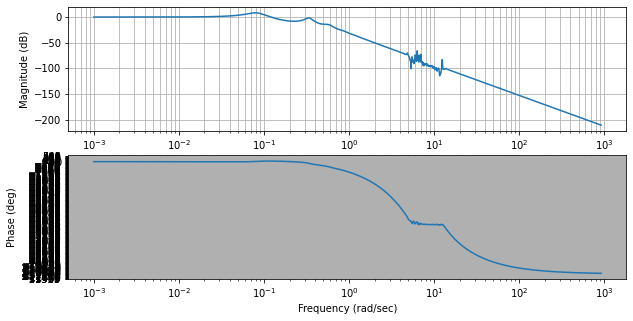

In [ ]:
# Dode tijd met Pade modelleren
deadtime = 10                     #deadtime in seconden
num, den = c.pade(deadtime,50)
Gdead = c.tf(num,den)
# Gdead = c.tf(num,den,dt)

#G = c.tf(G.num,G.den,dt)  #discreet procesmodel uit real-life case

# Controller
Kc = 2
Ti = 120
C = Kc * (1/(s*Ti))

# Connecteer alle functie tot een CL systeem
G = c.series(G,Gdead)
sys = c.series(C,G)
sys = c.feedback(sys,1,sign=-1)

# Bode diagram
plt.figure(figsize=[10,5])
c.bode(sys)
plt.show()

gm, pm, wg, wp = c.margin(sys)
print('Versterking marge: ', gm, 'dB')
print('Fase marge: ', pm, '° (in graden)')
print('Fase crossover freq (waar de fase -180 snijdt): ', wg)
print('Versterking crossover freq (waar de versterking 1 snijdt, ookwel gekend als 0 dB): ', wp)

# Stel een procesmodel op in het continu tijdsdomein



In [ ]:


model_d = harold.Transfer(model_ARX.G.num,model_ARX.G.den,tsample)
model_c = harold.undiscretize(model_d)
print(model_c.num)
print(model_c.den)

# Ontwerp een regelaar a.d.h.v. het continu procesmodel

Tip: (S)IMC, directe synthese, ...

Extra opdracht:

* Ontwerp een laagdoorlaatfilter
* Pas de filter toe op het gecapteerde uitgangssignaal 
* Vervolg de identificatie procedure

Wat is het effect op de kwaliteit van het model?